In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('asset_prices.csv', parse_dates=['Date'])


In [3]:
# Display the first few rows
print("First few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

# Describe the dataset
print("\nStatistical description of the dataset:")
print(df.describe())

First few rows of the dataset:
        Date     Asset_A     Asset_B     Asset_C     Asset_D
0 2000-01-01   87.454012   68.513293   76.170568  117.270299
1 2000-01-02  145.071431  104.190095   74.697880  129.668140
2 2000-01-03  123.199394  137.294584  140.625458   75.046790
3 2000-01-04  109.865848  123.222489   74.954620  112.487410
4 2000-01-05   65.601864  130.656115   77.194973  107.174598

Missing values in the dataset:
Date       0
Asset_A    0
Asset_B    0
Asset_C    0
Asset_D    0
dtype: int64

Statistical description of the dataset:
                      Date      Asset_A      Asset_B      Asset_C      Asset_D
count                 1000  1000.000000  1000.000000  1000.000000  1000.000000
mean   2001-05-14 12:00:00    99.025655   100.701731   100.240573    99.037505
min    2000-01-01 00:00:00    50.463202    50.321826    50.001163    50.065339
25%    2000-09-06 18:00:00    73.597327    74.107427    76.135098    74.190077
50%    2001-05-14 12:00:00    99.680738   101.873391   10

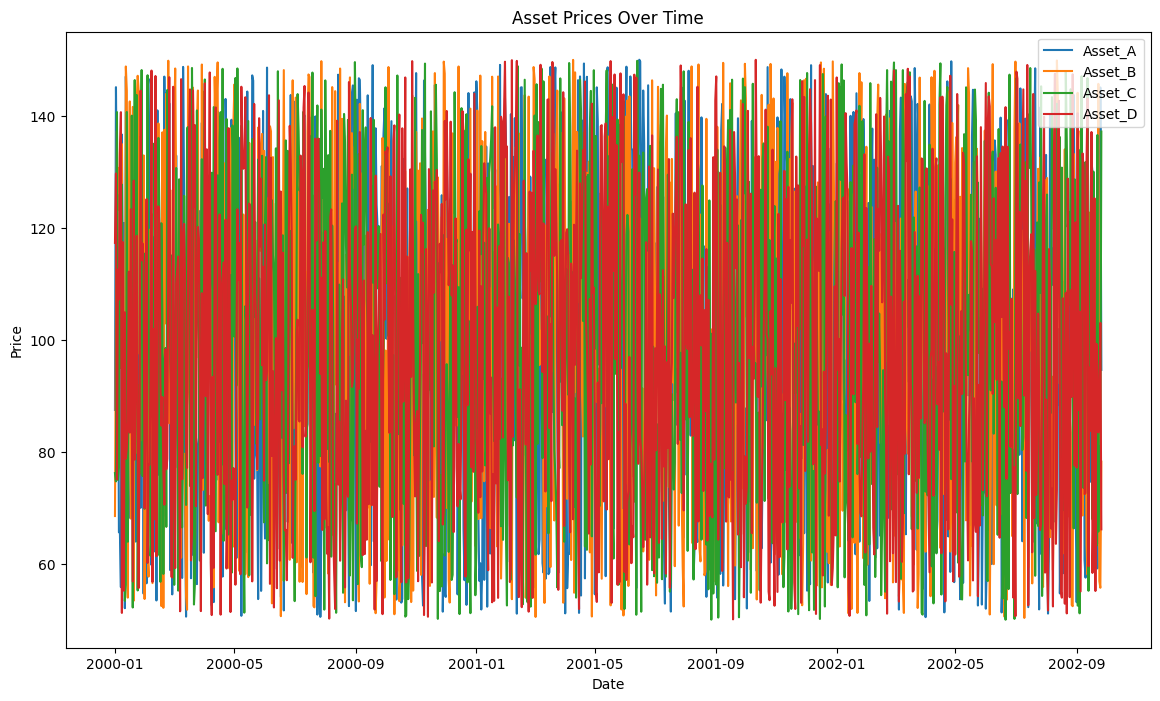

In [4]:
# Plotting the time series of each asset
plt.figure(figsize=(14, 8))
for column in df.columns[1:]:
    plt.plot(df['Date'], df[column], label=column)
plt.title('Asset Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

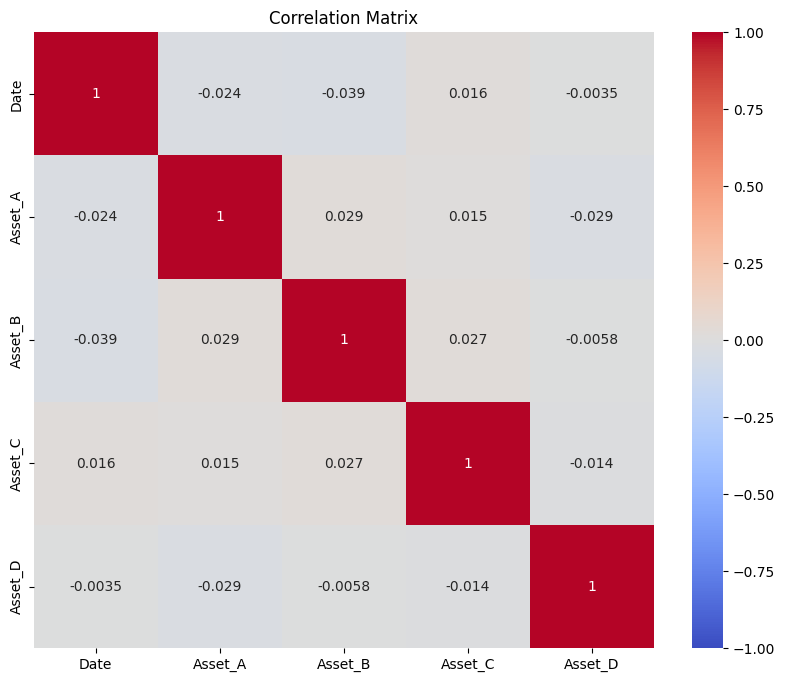

In [5]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

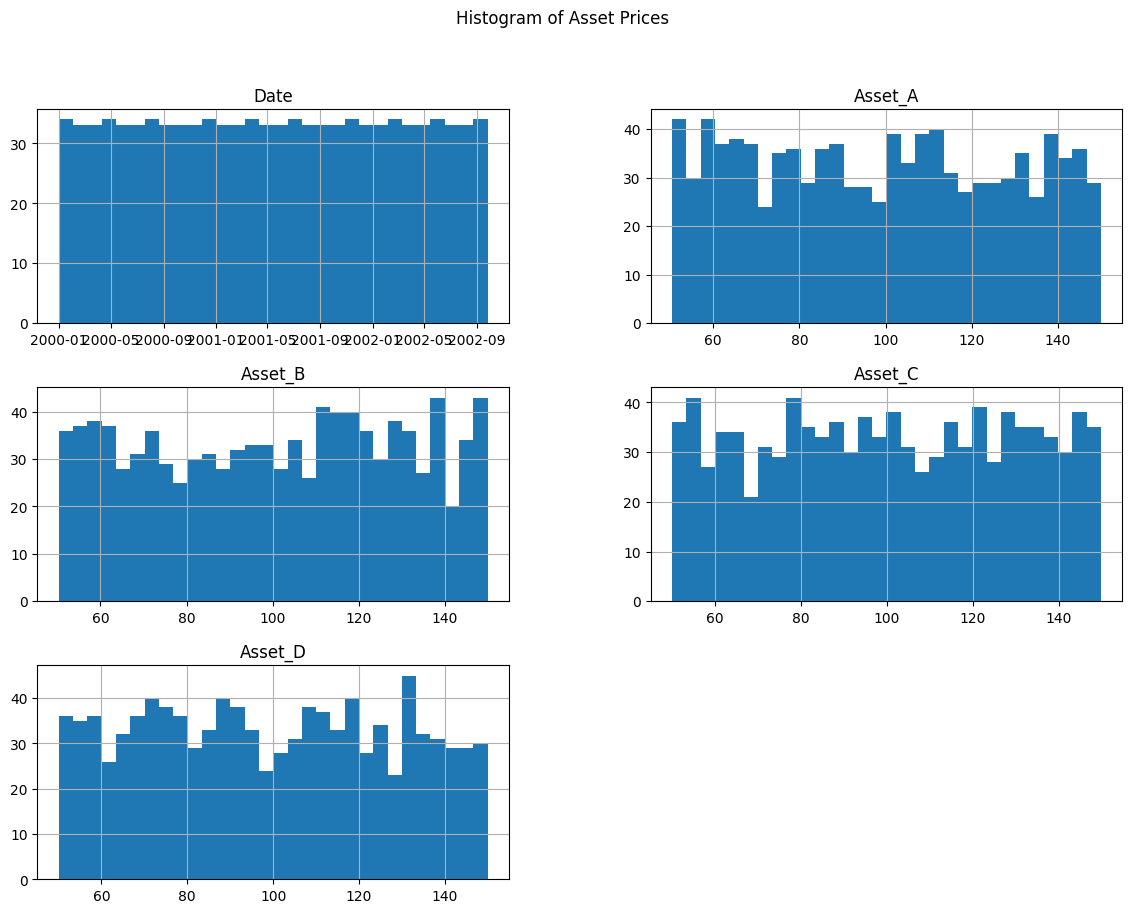

In [6]:
# Plot histograms of each asset
df.hist(bins=30, figsize=(14, 10))
plt.suptitle('Histogram of Asset Prices')
plt.show()

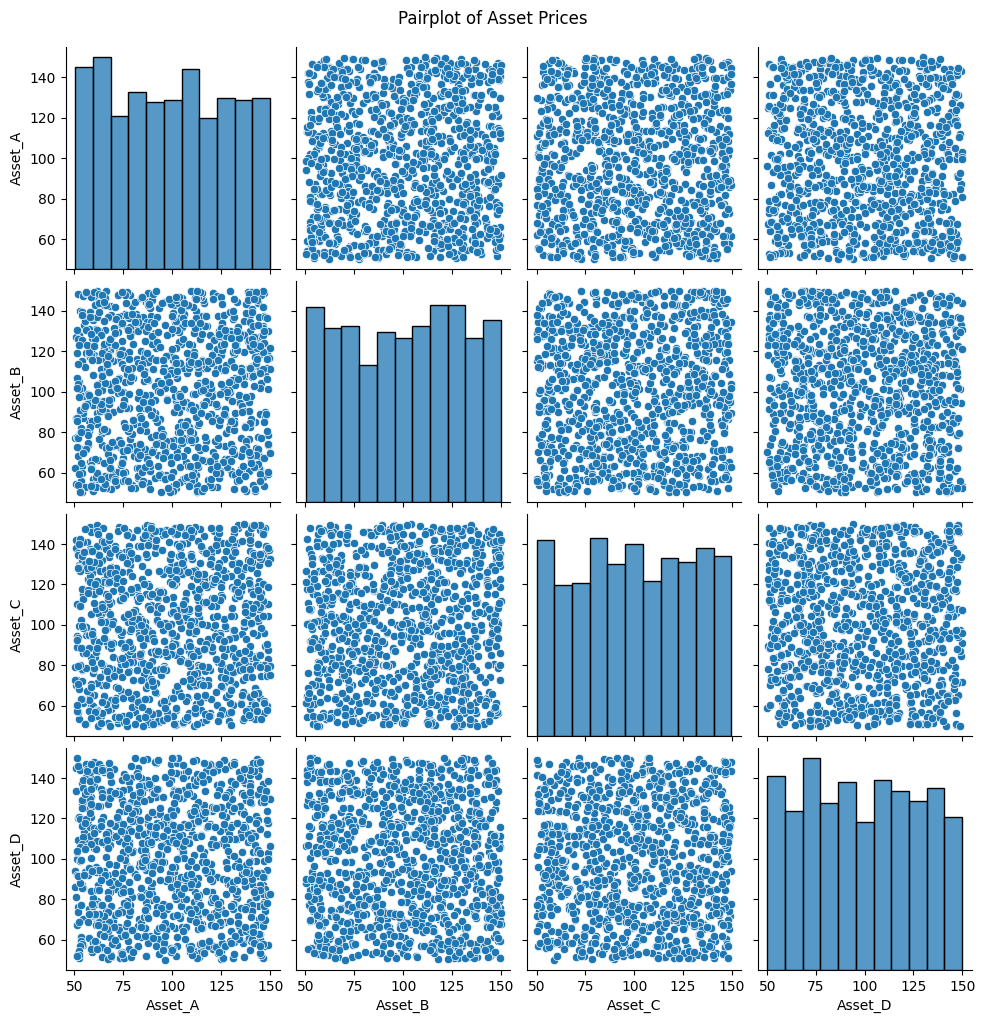

In [7]:
# Plot pairplot to see the relationships between assets
sns.pairplot(df.drop('Date', axis=1))
plt.suptitle('Pairplot of Asset Prices', y=1.02)
plt.show()

First few rows of daily returns:
             Asset_A   Asset_B   Asset_C   Asset_D
Date                                              
2000-01-02  0.658831  0.520728 -0.019334  0.105720
2000-01-03 -0.150767  0.317732  0.882590 -0.421240
2000-01-04 -0.108227 -0.102496 -0.466991  0.498897
2000-01-05 -0.402891  0.060327  0.029889 -0.047230
2000-01-06 -0.000037 -0.113104  0.631451  0.243607


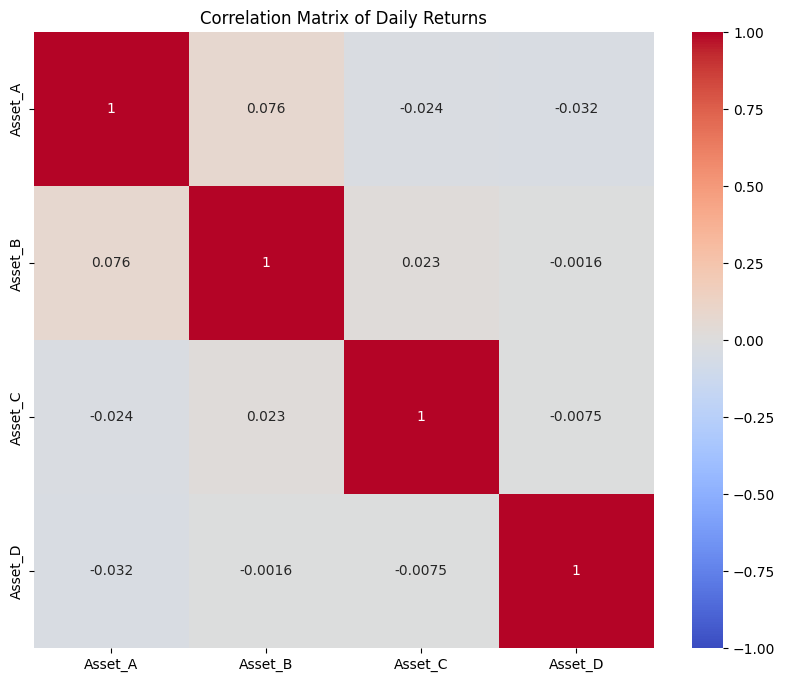

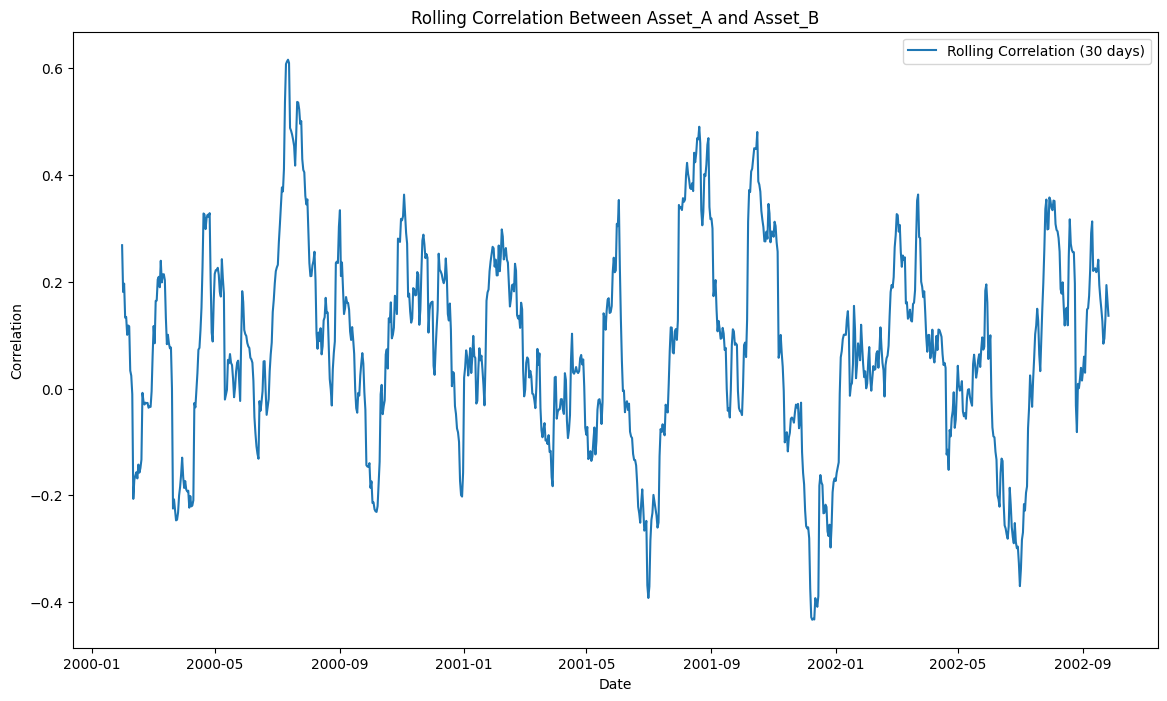

In [8]:
# Calculate daily returns
returns = df.set_index('Date').pct_change().dropna()

# Display the first few rows of returns
print("First few rows of daily returns:")
print(returns.head())

# Plot correlation matrix of returns
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Daily Returns')
plt.show()

# Calculate rolling correlation
rolling_corr = returns['Asset_A'].rolling(window=30).corr(returns['Asset_B'])

# Plot rolling correlation
plt.figure(figsize=(14, 8))
plt.plot(rolling_corr, label='Rolling Correlation (30 days)')
plt.title('Rolling Correlation Between Asset_A and Asset_B')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Calculate returns
returns = df.set_index('Date').pct_change().dropna()

# Select an asset column to work on (e.g., the first asset column after 'Date')
asset = df.columns[1]

# Fill missing values
df[asset] = df[asset].fillna(df[asset].mean())

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[asset].values.reshape(-1, 1))

# Split data into training and testing sets
training_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - training_size
train_data, test_data = scaled_data[0:training_size, :], scaled_data[training_size:len(scaled_data), :]

# Function to create datasets
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, batch_size=1, epochs=10)

# Predictions
train_predict_lstm = lstm_model.predict(X_train)
test_predict_lstm = lstm_model.predict(X_test)

# Inverse transform to get actual values
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)


Epoch 1/10
789/789 [==============================] - 8s 6ms/step - loss: 0.0962
Epoch 2/10
789/789 [==============================] - 6s 7ms/step - loss: 0.0907
Epoch 3/10
789/789 [==============================] - 5s 6ms/step - loss: 0.0900
Epoch 4/10
789/789 [==============================] - 5s 6ms/step - loss: 0.0886
Epoch 5/10
789/789 [==============================] - 6s 7ms/step - loss: 0.0887
Epoch 6/10
789/789 [==============================] - 5s 6ms/step - loss: 0.0883
Epoch 7/10
789/789 [==============================] - 7s 9ms/step - loss: 0.0888
Epoch 8/10
789/789 [==============================] - 6s 8ms/step - loss: 0.0878
Epoch 9/10
789/789 [==============================] - 8s 10ms/step - loss: 0.0877
Epoch 10/10
6/6 [==============================] - 0s 5ms/step


In [12]:
from tensorflow.keras.layers import GRU

# GRU Model
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
gru_model.add(GRU(50, return_sequences=False))
gru_model.add(Dense(25))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(X_train, y_train, batch_size=1, epochs=1)

# Predictions
train_predict_gru = gru_model.predict(X_train)
test_predict_gru = gru_model.predict(X_test)

# Inverse transform to get actual values
train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)


6/6 [==============================] - 0s 4ms/step


In [13]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# CNN Model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mean_squared_error')
cnn_model.fit(X_train, y_train, batch_size=1, epochs=1)

# Predictions
train_predict_cnn = cnn_model.predict(X_train)
test_predict_cnn = cnn_model.predict(X_test)

# Inverse transform to get actual values
train_predict_cnn = scaler.inverse_transform(train_predict_cnn)
test_predict_cnn = scaler.inverse_transform(test_predict_cnn)


6/6 [==============================] - 0s 2ms/step


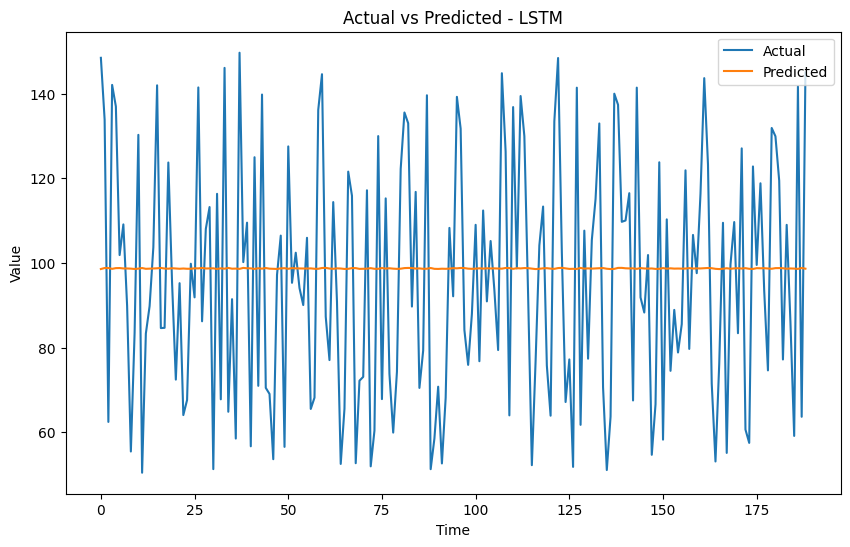

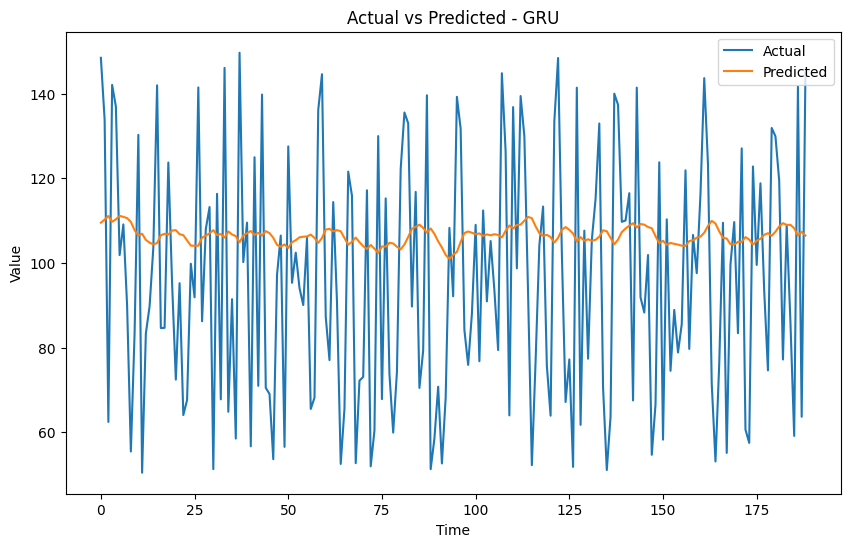

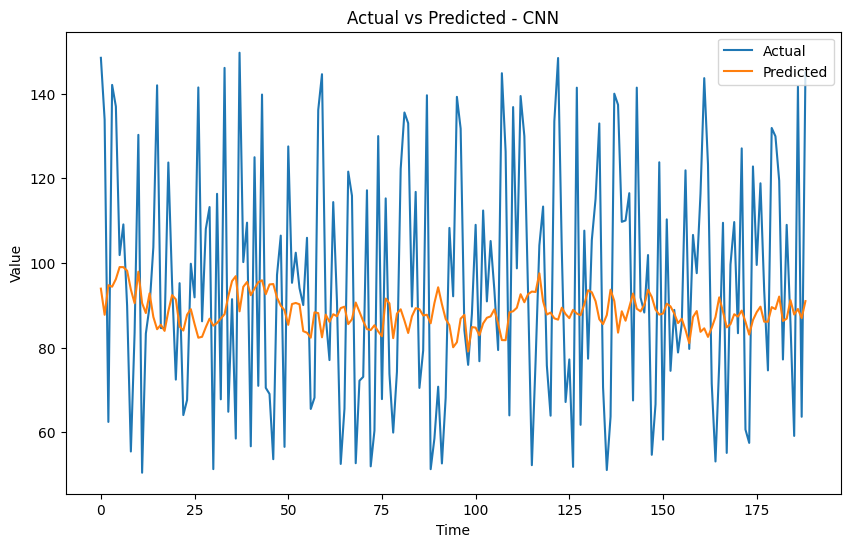

In [14]:
# Function to plot predictions
def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Evaluate and plot LSTM predictions
plot_predictions(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict_lstm, "LSTM")

# Evaluate and plot GRU predictions
plot_predictions(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict_gru, "GRU")

# Evaluate and plot CNN predictions
plot_predictions(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict_cnn, "CNN")
